<a href="https://colab.research.google.com/github/yrodriguezmd/IceVision_in_the_works/blob/main/Surg100_finetuning_oct1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-10-01 23:40:08--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]     595  --.-KB/s    in 0s      

2021-10-01 23:40:08 (30.1 MB/s) - ‘install_colab.sh’ saved [595/595]

- Installing mmcv
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.9.0/index.html
     |████████████████████████████████| 35.6 MB 125 kB/s 
     |████████████████████████████████| 185 kB 5.1 MB/s 
- Installing mmdet
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpb6wilqv6/mmdetection'...
remote: Enumerating objects: 211

In [3]:
exit()

In [ ]:
import icevision

In [3]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu102
torchvision v 0.10.0+cu102


In [4]:
#option 1: git clone
!git clone https://github.com/yrodriguezmd/Surgical_instruments.git
# initially run with no File9, later added

#option 2:
#colab upload

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (375/375), done.
remote: Total 421 (delta 77), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (421/421), 16.58 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [84]:
!ls

annot.json	    pilot15_for_pseudolabel  Surgical_instruments_
checkpoints	    sample_data		     Surgical_instruments__
install_colab.sh    Surg100_annot.json	     Surgical_instruments___
install_colab.sh.1  Surgical_instruments


In [85]:
!ls Surgical_instruments/project/Surg100
# 'a' removed

_annotations.csv  notebooks  raw_images  Surg_100_ann_coco  Surg100_annot


In [ ]:
!ls Surgical_instruments/project/Surg100/Surg_100_ann_coco/train

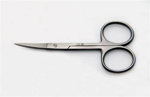

In [5]:
# new path after roboflow refining
image_path = Path('Surgical_instruments/project/Surg100/Surg_100_ann_coco/train/')
#image_path = Path('Surgical_instruments/project/Surg100/raw_images/')

## images better in a folder
img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0])
img = img.convert('RGB')

img.to_thumb(150,150)

In [16]:
# using roboflow TF csv
import pandas as pd
df = pd.read_csv('Surgical_instruments/project/Surg100/_annotations.csv',) 
df.rename(columns = {'class':'label'}, inplace=True)
df.head(3)
## no image width, height

filename  width  ...  xmax ymax
0  File00079_jpg.rf.071253c231bbcfed517a0f774afeabdf.jpg    400  ...   370  337
1  File00030_jpg.rf.07c0246f71a499249cb5aed1782f0dcf.jpg    300  ...   297  150
2  File00050_jpg.rf.0b3a5281c774bf199c46855a8b5ad799.jpg    303  ...   184  571

[3 rows x 8 columns]

In [17]:
_CLASSES = df.label.unique().tolist()
_CLASSES

['Yankauer',
 'Hemostat',
 'Army_navy',
 'Richardson',
 'Potts',
 'Forceps',
 'Towel_clip',
 'Frazier',
 'Weitlaner',
 'Needle',
 'Scalpel',
 'Castroviejo',
 'Bulldog',
 'Iris',
 'Mayo_metz']

In [89]:
len(df.label.unique())

15

In [6]:
from icevision.models.checkpoint import *

In [ ]:
!ls Surgical_instruments/project/Surg100/Surg_100_ann_coco/train

In [7]:
parser = parsers.COCOBBoxParser(
    annotations_filepath = Path('/content/Surgical_instruments/project/Surg100/Surg_100_ann_coco/train/_annotations.coco.json'), ##
    img_dir = Path('/content/Surgical_instruments/project/Surg100/Surg_100_ann_coco/train/', ##
    mask =False)
)

In [8]:
train_records, valid_records = parser.parse()

  0%|          | 0/130 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/98 [00:00<?, ?it/s]

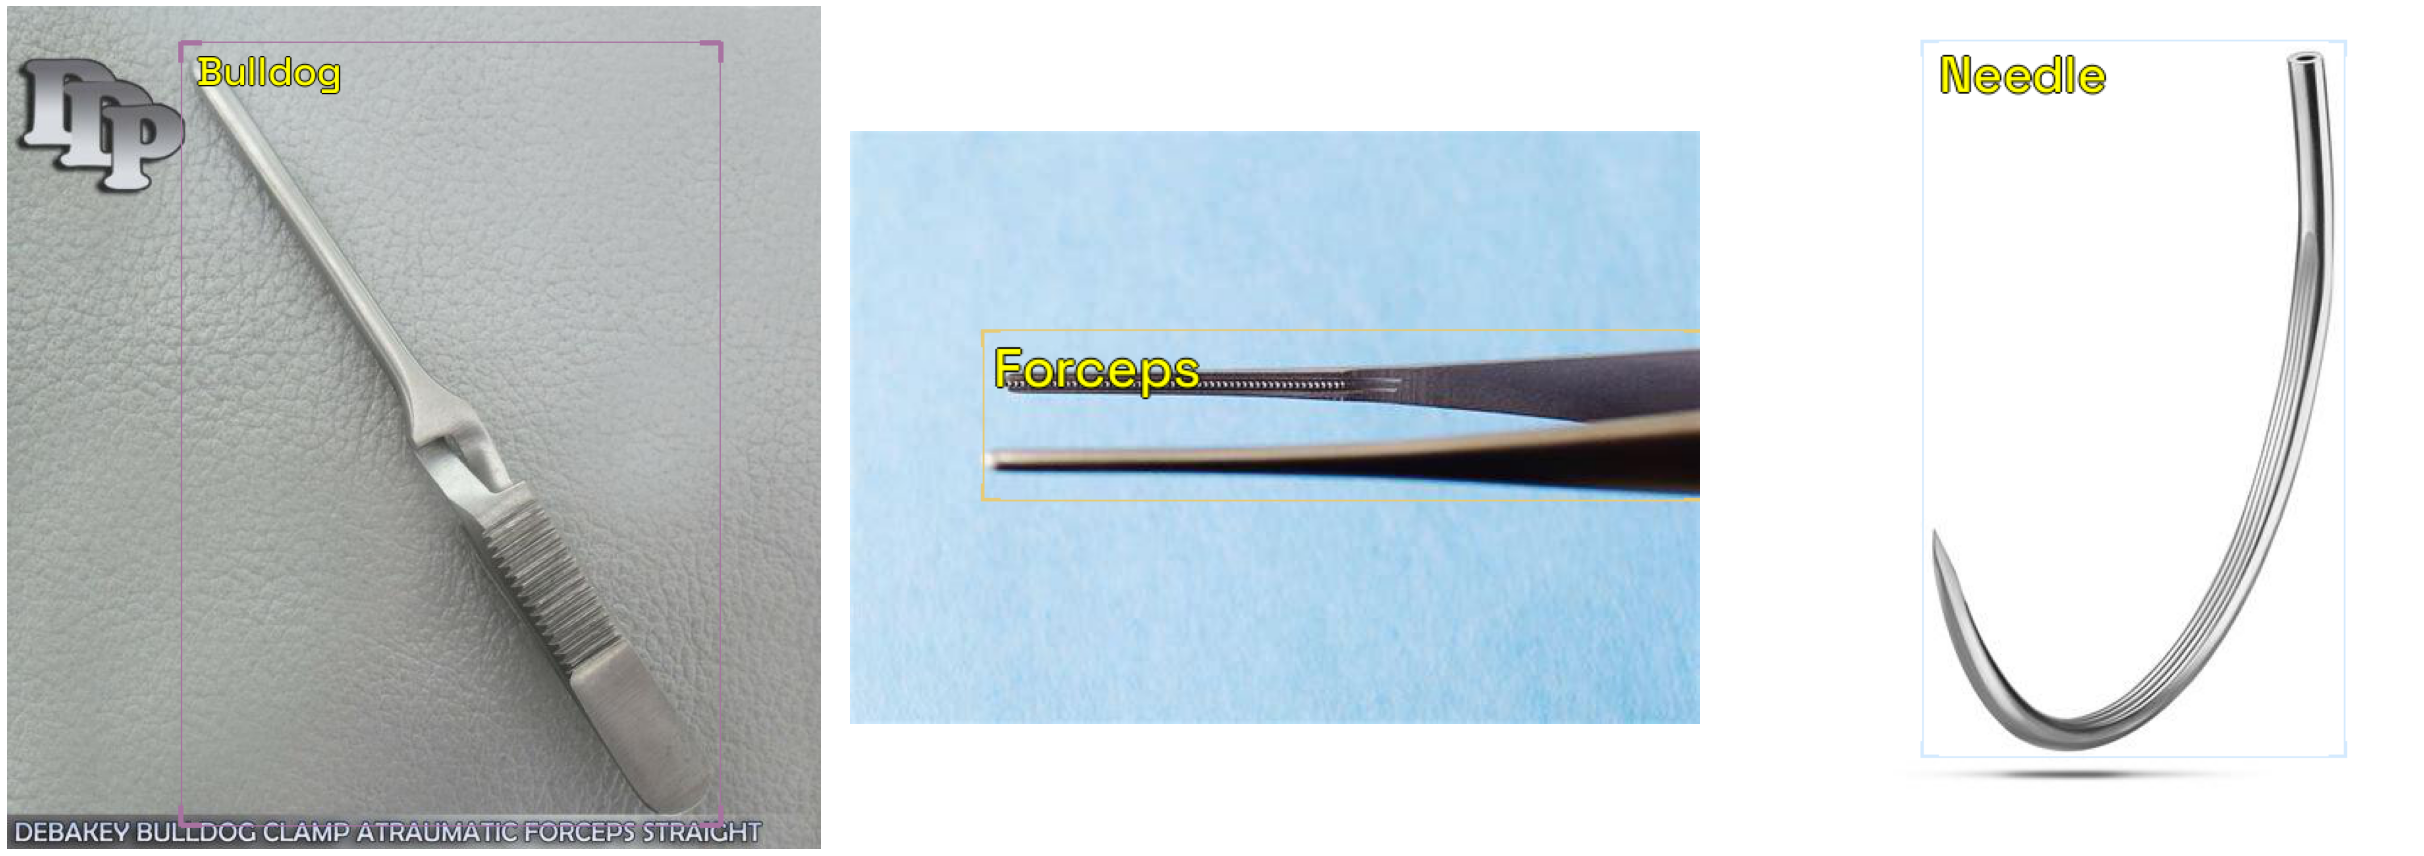

In [114]:
show_records(train_records[:3], ncols=3, font_size=30, label_color = '#ffff00')

In [9]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [10]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

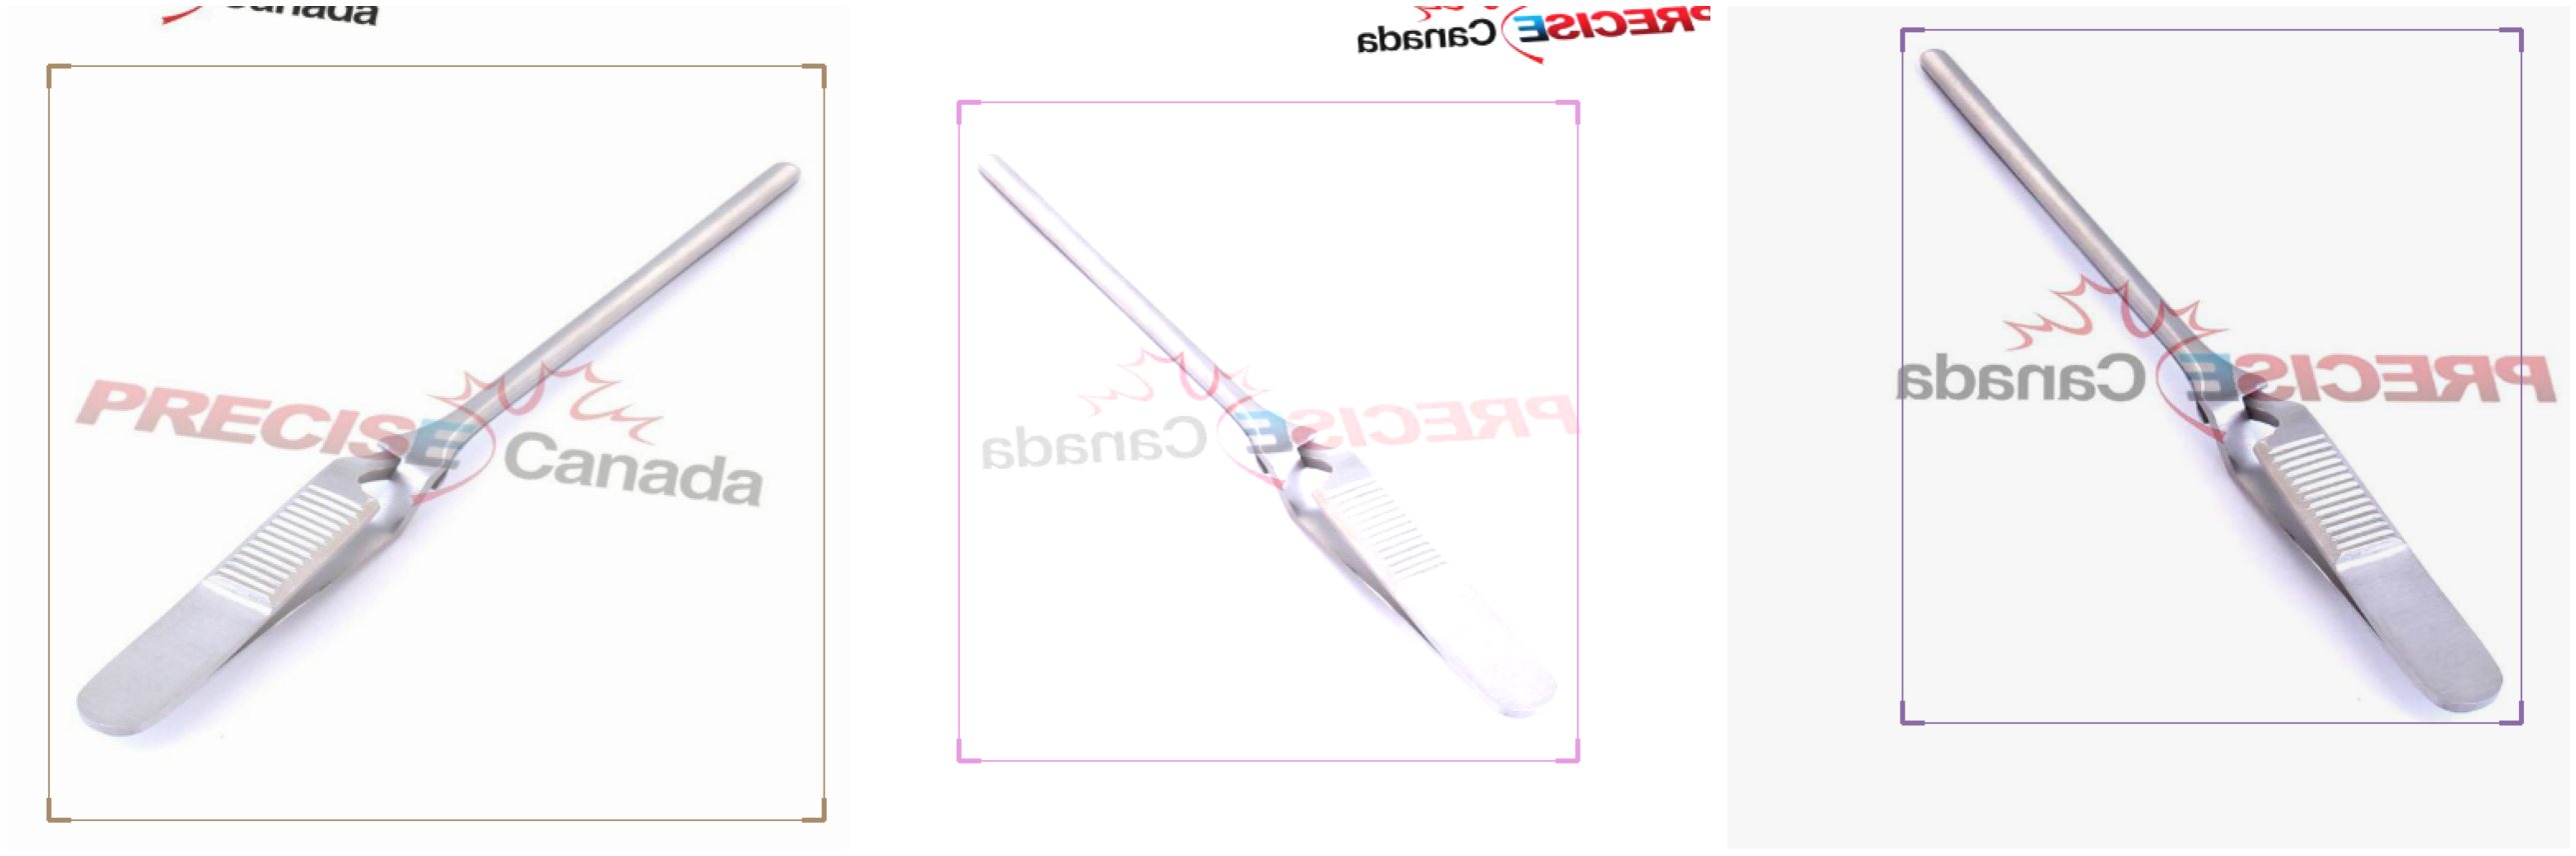

In [117]:
samples = [train_ds[6] for _ in range(3)]
show_samples(samples, ncols=3, display_label=False)

In [11]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [18]:
model_type = models.mmdet.vfnet
backbone = model_type.backbones.resnet50_fpn_mstrain_2x

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(_CLASSES),)# **extra_args) 

  0%|          | 0/131902412 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2021-10-01 23:45:52,970 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2021-10-01 23:45:52,972 - mmcv - INFO - load model from: torchvision://resnet50
2021-10-01 23:45:52,974 - mmcv - INFO - Use load_from_torchvision loader
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2021-10-01 23:45:56,148 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-10-01 23:45:56,185 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2021-10-01 23:45:56,213 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}}
2021-10-01 23:45:56,252 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-10-01 23:45:56,253 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-10-01 23:45:56,255 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-10-01 23:45:56,257 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64, 

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([14, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([14]).


In [120]:
backbone.__dict__

# filename diff on website, file down/uploaded
#retinanet_r50_caffe_fpn_1x_coco_20200531-f11027c5.pth

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': True,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

In [19]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0005754399462603033)

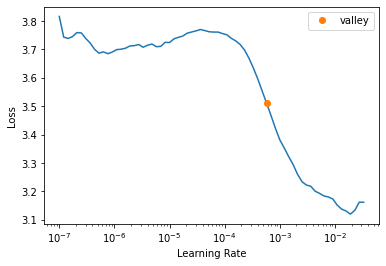

In [21]:
learn.lr_find()

In [22]:
learn.fine_tune(10, 0.0005754399462603033, freeze_epochs = 1)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=5.248074739938602e-05)

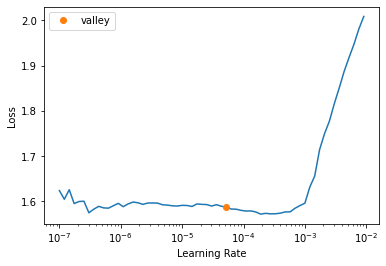

In [23]:
learn.lr_find()

In [24]:
from fastai.callback.tracker import SaveModelCallback
fname='Surg100_vfnet-best'
learn.unfreeze()
# will not use suggested lr_min, use graph
learn.fit_one_cycle(20, 5.248074739938602e-05, cbs=SaveModelCallback(monitor='COCOMetric', fname=fname))

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Better model found at epoch 0 with COCOMetric value: 0.3172346739188491.
Better model found at epoch 1 with COCOMetric value: 0.3420592635268906.
Better model found at epoch 2 with COCOMetric value: 0.3547718096373186.
Better model found at epoch 3 with COCOMetric value: 0.36109324489884054.
Better model found at epoch 4 with COCOMetric value: 0.4024090914506993.
Better model found at epoch 7 with COCOMetric value: 0.4673566894586012.


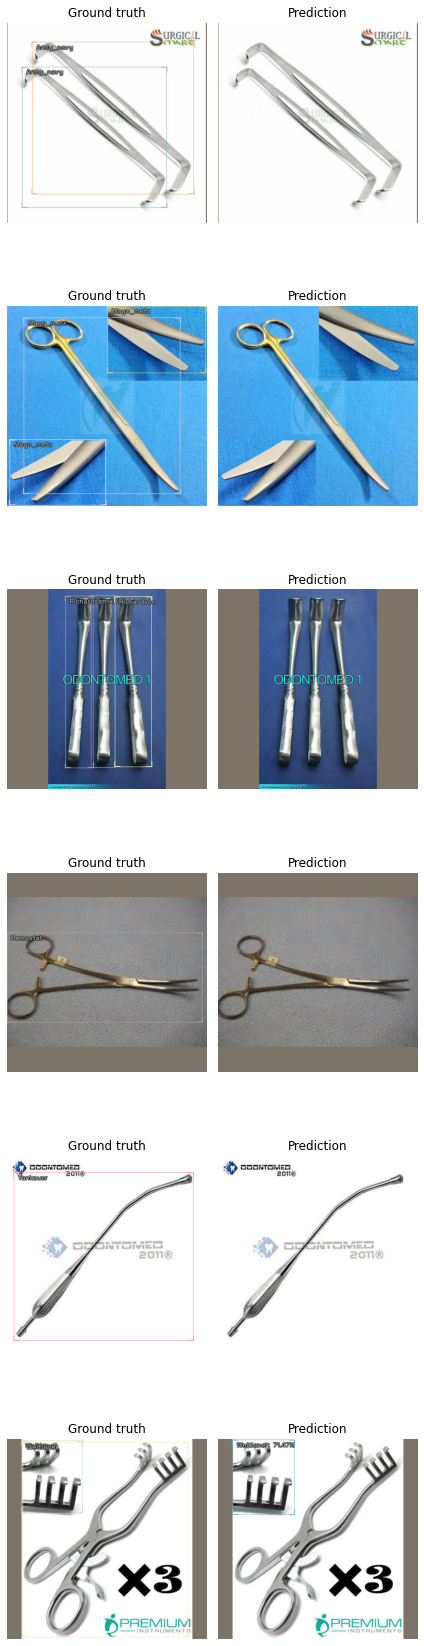

In [28]:
model_type.show_results(model, valid_ds) 

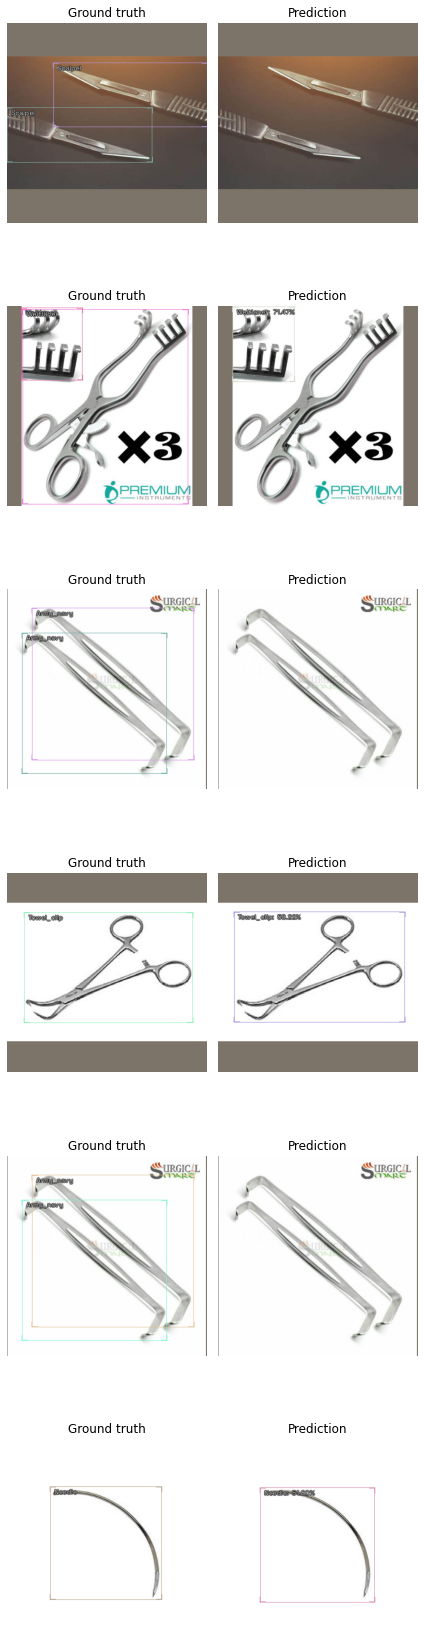

In [31]:
model_type.show_results(model, valid_ds) 

In [29]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = Path('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [30]:
!ls models

Surg100_vfnet-best.pth


In [ ]:
#!cp models/Surg100_vfnet-best.pth /content/gdrive/"My Drive"/models/Surg100_vfnet-best.pth

In [ ]:
# roboflow Surg100 with low reps for bulldog, iris, potts
# -> get 20 for each, 3-4 for the others

In [46]:
model.eval()

imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [47]:
len(imgs_array)

100

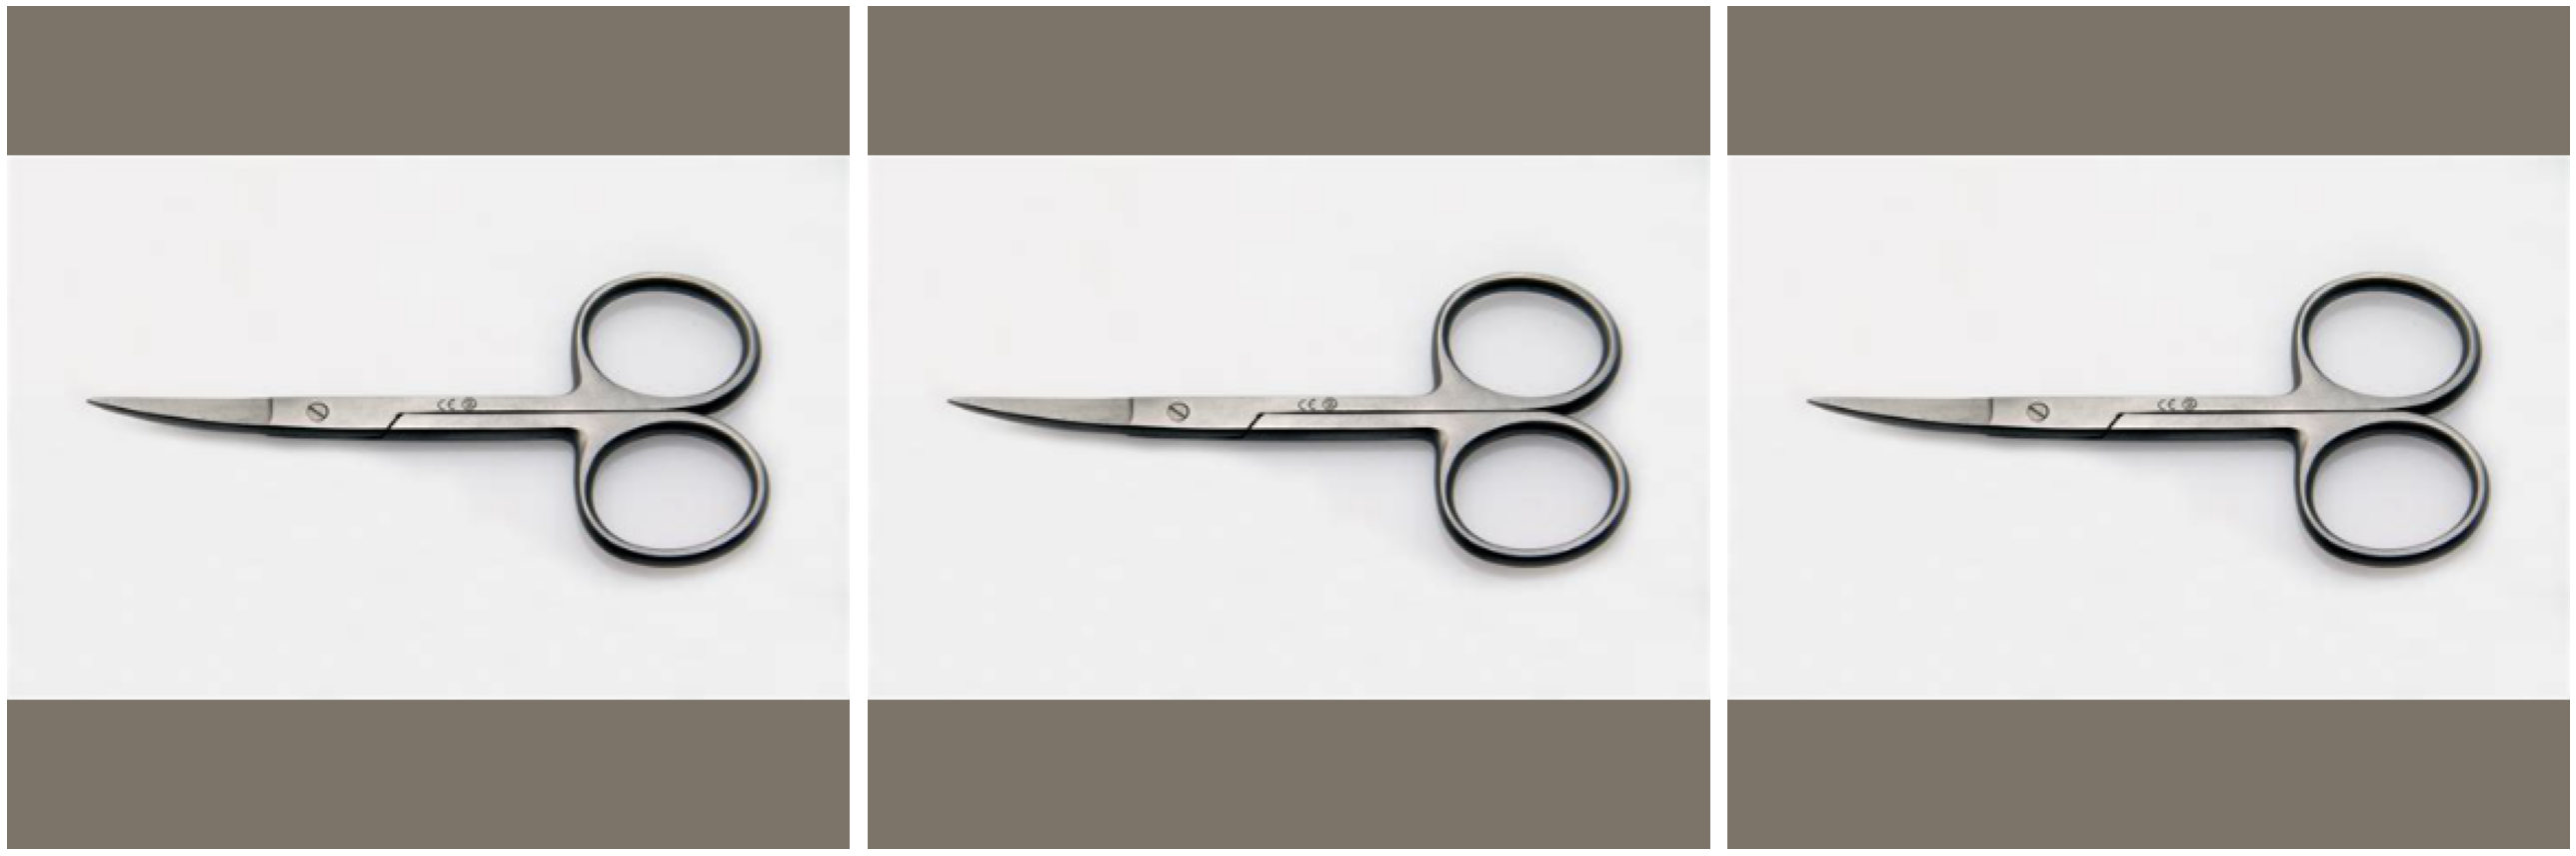

In [48]:
samples = [infer_ds[0] for _ in range(3)]
show_samples(samples, denormalize_fn = denormalize_imagenet, ncols=3)

In [49]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True,) # detection_threshold =0.5 default

  0%|          | 0/25 [00:00<?, ?it/s]

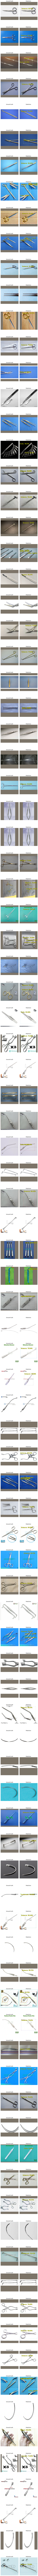

In [50]:
show_preds(preds_saved, font_size=30, label_color='#ffff00')
#https://github.com/airctic/icevision/blob/9abbb09f47e6fc18867a5aa662885b558af2975c/icevision/models/mmdet/common/bbox/prediction.py

In [ ]:
# other classes apart from scissors and knife:
# laptop (64), toothbrush (80), clock (75), person (1), spoon (45), fork (43)

In [51]:
preds_saved[0].pred

BaseRecord

common: 
	- Image size ImgSize(width=384, height=384)
	- Img: 384x384x3 <np.ndarray> Image
	- Record ID: 0
detection: 
	- BBoxes: [<BBox (xmin:37.63182067871094, ymin:121.11810302734375, xmax:345.36553955078125, ymax:255.51083374023438)>]
	- Class Map: <ClassMap: {'background': 0, 'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 12, 'parking meter': 13, 'bench': 14, 'bird': 15, 'cat': 16, 'dog': 17, 'horse': 18, 'sheep': 19, 'cow': 20, 'elephant': 21, 'bear': 22, 'zebra': 23, 'giraffe': 24, 'backpack': 25, 'umbrella': 26, 'handbag': 27, 'tie': 28, 'suitcase': 29, 'frisbee': 30, 'skis': 31, 'snowboard': 32, 'sports ball': 33, 'kite': 34, 'baseball bat': 35, 'baseball glove': 36, 'skateboard': 37, 'surfboard': 38, 'tennis racket': 39, 'bottle': 40, 'wine glass': 41, 'cup': 42, 'fork': 43, 'knife': 44, 'spoon': 45, 'bowl': 46, 'banana': 47, 'apple': 48, 'sandw

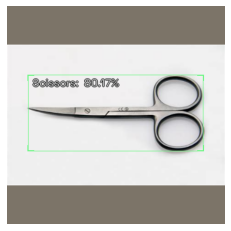

In [52]:
show_sample(preds_saved[0])

In [53]:
# adjusting base record to incorporate filepath
#https://github.com/airctic/icevision/blob/e60c2e2117c012ca5c323088f8577935a87c4f4e/icevision/core/record_components.py
for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

In [54]:
# adding the filepath for each file after adjusting baserecord
for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

In [ ]:
for _ in range(len(preds_saved)):
  print(preds_saved[_].pred)

In [ ]:
conv = convert_preds_to_coco_style(preds_saved) ##
conv
## bboxes in xmin(x top left), ymin (y top left), w, h
# same as convert_records_to_coco_style(preds_saved)
# https://github.com/airctic/icevision/blob/master/icevision/data/convert_records_to_coco_style.py#L78
# https://github.com/pytorch/vision/blob/master/references/detection/coco_utils.py

In [57]:
conv['annotations'][0] # based on preds_saved

{'area': 41357.17,
 'bbox': [37.63182, 121.1181, 307.7337, 134.39273],
 'category_id': 77,
 'id': 1,
 'image_id': 0,
 'iscrowd': 0,
 'score': 0.8016772}

In [58]:
add_info = {
    "info": {
    "description": "Surgery Instruments",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2021,
    "contributor": "MR",
    "date_created": "2021/09/27"
    },
  "categories": [
                 ## adjusted to 80 classes, 
                 ## limiting categories to relevant classes
                 # not including 'person' and 'clock'
    {
      "supercategory": "kitchen",
      "id": 43,
      "name": "fork"
    },
    {
      "supercategory": "kitchen",
      "id": 44,
      "name": "knife"
    },
    {
      "supercategory": "kitchen",
      "id": 45,
      "name": "spoon"
    },
    {
      "supercategory": "electronic",
      "id": 64,
      "name": "laptop"
    },
    {
      "supercategory": "indoor",
      "id": 77,
      "name": "scissors"
    },
    {
      "supercategory": "indoor",
      "id": 80,
      "name": "toothbrush"
    }
    ] }

In [59]:
annot = {**add_info, **conv}
annot

{'annotations': [{'area': 41357.17,
   'bbox': [37.63182, 121.1181, 307.7337, 134.39273],
   'category_id': 77,
   'id': 1,
   'image_id': 0,
   'iscrowd': 0,
   'score': 0.8016772},
  {'area': 38788.977,
   'bbox': [25.907959, 143.16191, 289.8979, 133.8022],
   'category_id': 77,
   'id': 2,
   'image_id': 1,
   'iscrowd': 0,
   'score': 0.81561226},
  {'area': 32111.705,
   'bbox': [96.58162, 81.60109, 283.79285, 113.15192],
   'category_id': 44,
   'id': 3,
   'image_id': 2,
   'iscrowd': 0,
   'score': 0.65933526},
  {'area': 26746.324,
   'bbox': [0.56781006, 162.94217, 273.1521, 97.91733],
   'category_id': 44,
   'id': 4,
   'image_id': 2,
   'iscrowd': 0,
   'score': 0.6574549},
  {'area': 77230.17,
   'bbox': [40.78244, 82.07413, 330.45016, 233.712],
   'category_id': 77,
   'id': 5,
   'image_id': 3,
   'iscrowd': 0,
   'score': 0.867951},
  {'area': 56801.8,
   'bbox': [23.155457, 107.65831, 338.18253, 167.96196],
   'category_id': 77,
   'id': 6,
   'image_id': 4,
   'iscro

In [60]:
## saving dictionary as json file

f = open('Surg100_annot.json','w') 
f.write(str(annot)) 
f.close()

In [ ]:
# open json in VS code or text editor, replace ' with "
# upload in roboflow

In [ ]:
# roboflow annotated
# no transforms, no resizing on roboflow
# export annotated file (in coco json form) and images

In [ ]:
#!ls

In [ ]:
# after annotating in roboflow
# use images downloaded with the annotations
#parser = parsers.COCOBBoxParser(
#    annotations_filepath = Path('/content/pilot15_roboflow/_annotations.coco.json'), ##
#    img_dir = Path('/content/pilot15_roboflow/', ##
#    mask =False)
#)

In [ ]:
#data_splitter = RandomSplitter([1.0,0])  # default 0.8,0.2
#train_records, valid_records = parser.parse(data_splitter)# default autofix=True

In [ ]:
#show_records(train_records[:3],ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
#show_records(train_records[3:],ncols=3, font_size=30, label_color = '#ffff00')


In [ ]:
## option to decrease detection threshold, to have more baseline annotations, but mostly
#  incorrect

In [ ]:
# using model pretrained on coco
CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
               'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
               'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
               'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
               'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush')
class_map = ClassMap(CLASSES)
len(class_map)
# 80 + background

81